The notebook contains three ML models for landslide susceptibility mapping: Random Forest (RF), Logistic Regression (LR) and Support Vector Machine (SVM) without climate variables (Predictor Set I)

In [1]:
from pyspatialml import Raster
import os
import matplotlib.pyplot as plt
import geopandas
import pandas as pd
import seaborn as sn
import rasterio.plot
import numpy as np
import matplotlib as mpl
import os
import geopandas as gpd
import numpy as np
from tempfile import NamedTemporaryFile
import warnings
warnings.filterwarnings('ignore')

Setting up the working directory:

In [2]:
#os.chdir(r'F:\landslides\Denmark_LSM_env_lsm\Data')
os.chdir(r'D:\Yenbai_PCA\DEM_variables')

Loading the preprocessed landslide presence/absebce points

In [3]:
data=pd.read_csv('data_final.csv')

In [4]:
data.head()

,dem_elevation,lulc,ndvi,ndwi,rivers,roads,lithology,faults,twi,spi,tri,slope,aspect,profile,plan,Landslide
0,1507.0,6.0,6.0,-0.470232,301.0,50.0,66.0,501.0,12.729965,-4777.923340,9.899495,17.349325,140.194427,0.006387,-0.003023,0
1,1051.0,6.0,6.0,-0.505809,200.0,450.0,66.0,501.0,7.422777,6742.672852,7.348469,13.674946,99.462318,-0.012059,-0.024882,0
2,1227.0,6.0,6.0,-0.815217,150.0,150.0,66.0,500.0,13.313554,-1644.321167,6.164414,8.206727,303.690063,-0.020048,0.010241,0
3,872.0,6.0,6.0,-0.570341,200.0,501.0,66.0,501.0,12.767640,-697.416504,11.090536,17.744671,180.000000,0.011059,0.040000,0
4,2107.0,6.0,6.0,-0.786223,301.0,501.0,66.0,200.0,15.079862,-15198.347656,7.937254,14.366056,218.659805,-0.000710,-0.021941,0


In [5]:
data.describe()

,dem_elevation,lulc,ndvi,ndwi,rivers,roads,lithology,faults,twi,spi,tri,slope,aspect,profile,plan,Landslide
count,572.000000,572.000000,572.000000,572.000000,572.000000,572.000000,572.000000,572.000000,572.000000,5.720000e+02,572.000000,572.000000,572.000000,572.000000,572.000000,572.000000
mean,1353.456294,5.688811,5.765734,-0.555060,190.641608,257.479021,69.739510,454.550699,11.109957,-3.918464e+03,11.328153,19.141922,187.871510,-0.000295,0.001541,0.500000
std,388.406890,1.011846,0.685870,0.217702,95.882403,187.956952,9.086295,113.466379,3.681333,8.718968e+04,5.135284,8.150492,94.103094,0.007556,0.047602,0.500438
min,470.000000,1.000000,2.000000,-0.877032,50.000000,50.000000,1.000000,50.000000,3.162856,-1.874437e+06,1.414214,2.290610,4.085617,-0.025660,-0.320000,0.000000
25%,1068.000000,6.000000,6.000000,-0.748775,100.000000,100.000000,66.000000,501.000000,7.684280,-1.451920e+03,8.062258,14.066447,120.240936,-0.005303,-0.013562,0.000000
50%,1312.500000,6.000000,6.000000,-0.569075,200.000000,200.000000,66.000000,501.000000,12.232399,2.296909e+01,10.535654,18.255058,192.761711,-0.000000,-0.000000,0.500000
75%,1616.250000,6.000000,6.000000,-0.417680,301.000000,501.000000,81.000000,501.000000,14.007471,1.534045e+03,13.527749,23.396502,252.623943,0.004600,0.017961,1.000000
max,2478.000000,7.000000,6.000000,0.593315,301.000000,501.000000,105.000000,501.000000,19.162764,3.938505e+05,44.011364,55.748333,360.000000,0.030614,0.320000,1.000000


Dropping columns with climate data

In [6]:
#data= data.drop(columns=['average_temp_ref', 'cloudburst_ref', 'groundwater_ref', 'rain_average_ref', 'rain_max_day_ref'])


In [7]:
predictors = ['dem_elevation.tif', 'lulc.tif', 'ndvi.tif', 'ndwi.tif', 'rivers.tif', 'roads.tif', 'lithology.tif', 'faults.tif', 'twi.tif', 'spi.tif', 'tri.tif', 'slope.tif', 'aspect.tif', 'profile.tif','plan.tif']
#predictors = ['dem_elevation.tif', 'lulc.tif', 'TWI.tif', 'TPI.tif', 'TRI.tif', 'SPI.tif', 'eastness.tif','northerness.tif', 'profile_curvature.tif', 'slope.tif', 'roughness.tif', 'rivers.tif', 'roads.tif', 'geology.tif', 'faults.tif', 'arvi.tif', 'dvi.tif', 'evi.tif', 'ndvi.tif', 'ndwi.tif']
#, 'arvi.tif', 'dvi.tif', 'evi.tif', 'gari.tif', 'gemi.tif', 'ipvi.tif', 'msavi2.tif', 'ndvi.tif', 'ndwi.tif', 'pvi.tif', 'savi.tif', 'vari.tif', 'wdvi.tif'
#predictors =['dem_elevation.tif', 'TWI.tif', 'TPI.tif', 'TRI.tif', 'SPI.tif', 'easterness.tif', 'northerness.tif', 'slope_std.tif',  'distance_coast.tif', 'distance_streams.tif', 'soil.tif', 'geomorphology.tif', 'underground.tif', 'prequaternary.tif']

making a raster stack out of predictors

In [8]:
#print ("Current working dir : %s" % os.getcwd())
stack = Raster(predictors)

In [9]:
stack.names

dict_keys(['dem_elevation', 'lulc', 'ndvi', 'ndwi', 'rivers', 'roads', 'lithology', 'faults', 'twi', 'spi', 'tri', 'slope', 'aspect', 'profile', 'plan'])

Plotting variables

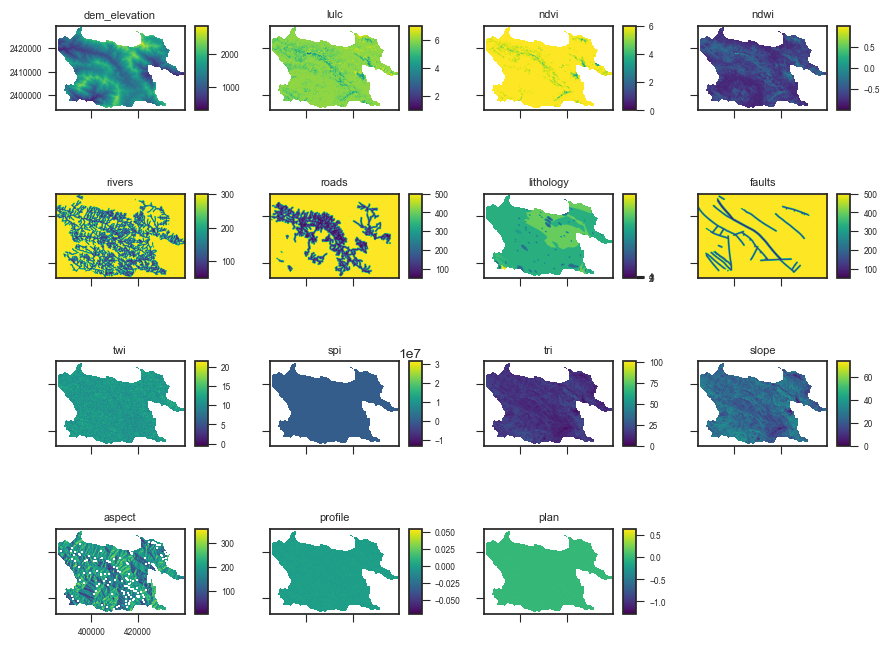

In [10]:
mpl.style.use('seaborn-ticks')
axs = stack.plot(figsize=(9, 7))
ax = axs.flatten()[6]
im = ax.images
im[0].colorbar.set_ticks([1,2,3,4])
ax = axs.flatten()[8]
ax.tick_params(axis='x', labelrotation=65)

plt.tight_layout()
plt.show()

In [11]:
#stack = stack.intersect() - if variables have different extent

Importing packages for Machine Learning

In [12]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

In [13]:
#index of numerical features from the dataset
numerical_features = [0, 1, 2, 3, 4, 5, 6]   #'dem_elevation', 'TWI', 'TPI', 'TRI', 'SPI', 'eastness', 'northerness', 'slope_std', 'distance_coast', 'distance_streams'

In [14]:
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numerical_features)])

Separating features from class labels

In [15]:
X = data.loc[:, stack.names]

In [16]:
X[:3]

,dem_elevation,lulc,ndvi,ndwi,rivers,roads,lithology,faults,twi,spi,tri,slope,aspect,profile,plan
0,1507.0,6.0,6.0,-0.470232,301.0,50.0,66.0,501.0,12.729965,-4777.923340,9.899495,17.349325,140.194427,0.006387,-0.003023
1,1051.0,6.0,6.0,-0.505809,200.0,450.0,66.0,501.0,7.422777,6742.672852,7.348469,13.674946,99.462318,-0.012059,-0.024882
2,1227.0,6.0,6.0,-0.815217,150.0,150.0,66.0,500.0,13.313554,-1644.321167,6.164414,8.206727,303.690063,-0.020048,0.010241


Our labels

In [17]:
y = data["Landslide"]

In [18]:
y[:3]

0    0
1    0
2    0
Name: Landslide, dtype: int64

Splitting our data into a training (70% of the data) and a testing set (30%), stratified after classes, so that we get the same amount of landslide and non-landslide samples in both sets. Random_sate= 42 for reproducebility

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

Checking the number of points in testing and training data

In [20]:
X_train.shape

(400, 15)

In [21]:
X_test.shape

(172, 15)

## Random Forest model

In [22]:
# Type of scoring used to compare parameter combinations
acc_scorer = make_scorer(accuracy_score)

In [23]:
# Create the  grid for hyperparametertuning
grid_rf = {'classifier__n_estimators': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 120, 140],
           'classifier__max_features': ['auto', 'sqrt', 'log2']}
print(grid_rf)

{'classifier__n_estimators': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 120, 140], 'classifier__max_features': ['auto', 'sqrt', 'log2']}


In [24]:
# Create a classifier
rf = RandomForestClassifier(random_state=42)

 "Pipeline" is for making workflow with standardization and classification in a few lines of code

In [25]:
rf_flow = Pipeline([
    ('preproc', preprocessor),
    ('classifier', rf)
])

In [26]:
from sklearn.model_selection import cross_validate, KFold
from sklearn.model_selection import GridSearchCV

In [27]:
# Instantiate the grid search model with 10-fold cross-validation
kfold = KFold(n_splits=10, shuffle=True, random_state=42)
model_rf = GridSearchCV(rf_flow, param_grid = grid_rf, cv = kfold, scoring=acc_scorer)

In [28]:
model_rf.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=10, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preproc',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         [0, 1,
                                                                          2, 3,
                                                                          4, 5,
                                                                          6])])),
                                       ('classifier',
                                        RandomForestClassifier(random_state=42))]),
             param_grid={'classifier__max_features': ['auto', 'sqrt', 'log2'],
                         'classifier__n_estimators': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 120,
                                                      140]},
             scoring=make_scorer(accuracy_score))

Best parameters from the grid search

In [29]:
model_rf.best_params_

{'classifier__max_features': 'sqrt', 'classifier__n_estimators': 20}

Using the test data for prediction

In [30]:
y_pred_rf = model_rf.predict(X_test)

Printing classification report

In [31]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_rf, target_names = ['non-landslide', 'landslide']))

               precision    recall  f1-score   support

non-landslide       0.75      0.76      0.75        86
    landslide       0.75      0.74      0.75        86

     accuracy                           0.75       172
    macro avg       0.75      0.75      0.75       172
 weighted avg       0.75      0.75      0.75       172



Printing confusion matrix

In [32]:
#from sklearn.metrics import plot_confusion_matrix, accuracy_score, confusion_matrix
from sklearn.metrics import accuracy_score, confusion_matrix
print(confusion_matrix(y_test, y_pred_rf))

[[65 21]
 [22 64]]


Doing it in a better visual way

In [33]:
from sklearn.metrics import ConfusionMatrixDisplay

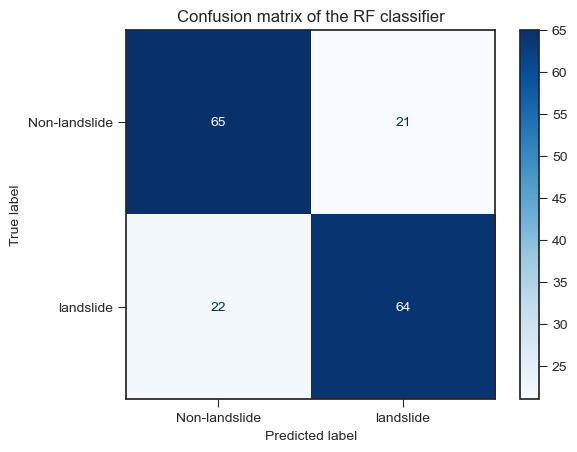

In [34]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_rf, 
                                        cmap="Blues", 
                                        display_labels=["Non-landslide", "landslide"])

plt.title('Confusion matrix of the RF classifier')
plt.show()

Printing overall accuracy (all the correctly classified samples divided by the total number of samples)

In [35]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, y_pred_rf))

0.75


Checking how our model is different from a classification created by a random process

In [36]:
from sklearn.metrics import cohen_kappa_score
print(cohen_kappa_score(y_test, y_pred_rf))

0.5


Plotting ROC_AUC

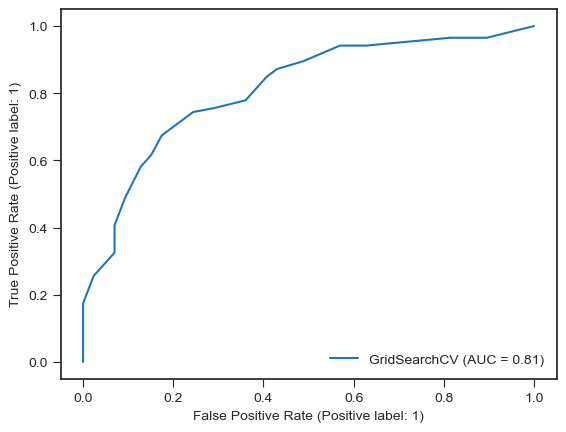

In [37]:
from sklearn import metrics
#from sklearn.metrics import roc_curve, auc
from sklearn.metrics import RocCurveDisplay
#metrics.plot_roc_curve(model_rf, X_test, y_test)  

RocCurveDisplay.from_estimator(model_rf, X_test, y_test)
plt.show() 

## Support Vector Machine model

In [38]:
from sklearn.svm import SVC

In [39]:
param_grid_SVM = [
  {'classifier__C': [0.001, 0.1, 1, 10], 'classifier__gamma': [1, 0.1, 0.01,0.001, 0.0001, 'scale', 'auto'], 'classifier__kernel': ['rbf']},
 ]


In [40]:
# Create a model


#svm_flow = Pipeline([
#    ('preproc', preprocessor),
#    ('classifier', svm)
#])

svm_flow = Pipeline(steps=[('standardscaler', StandardScaler()),('classifier', SVC(probability=True, gamma='auto'))])

# Instantiate the grid search model with 10-fold cross-validation
inner = KFold(n_splits=10, shuffle=True, random_state=42)
model_svm = GridSearchCV(svm_flow, param_grid = param_grid_SVM, cv = inner, scoring=acc_scorer)


# Fit the grid search to the data
model_svm.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=10, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('classifier',
                                        SVC(gamma='auto', probability=True))]),
             param_grid=[{'classifier__C': [0.001, 0.1, 1, 10],
                          'classifier__gamma': [1, 0.1, 0.01, 0.001, 0.0001,
                                                'scale', 'auto'],
                          'classifier__kernel': ['rbf']}],
             scoring=make_scorer(accuracy_score))

In [41]:
model_svm.best_params_

{'classifier__C': 1, 'classifier__gamma': 'scale', 'classifier__kernel': 'rbf'}

In [42]:
y_pred_svm = model_svm.predict(X_test)

In [43]:
print(classification_report(y_test, y_pred_svm, target_names = ['non-landslide', 'landslide']))


               precision    recall  f1-score   support

non-landslide       0.72      0.83      0.77        86
    landslide       0.80      0.69      0.74        86

     accuracy                           0.76       172
    macro avg       0.76      0.76      0.75       172
 weighted avg       0.76      0.76      0.75       172



In [44]:
print(accuracy_score(y_test, y_pred_svm))

0.7558139534883721


In [45]:
print(cohen_kappa_score(y_test, y_pred_svm))

0.5116279069767442


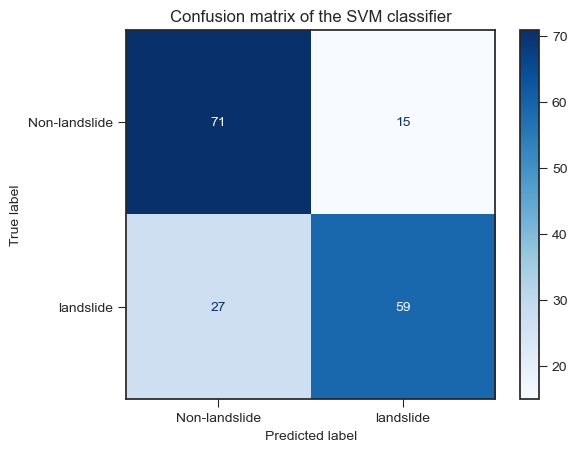

In [46]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_svm, 
                                        cmap="Blues", 
                                        display_labels=["Non-landslide", "landslide"])

plt.title('Confusion matrix of the SVM classifier')
plt.show()

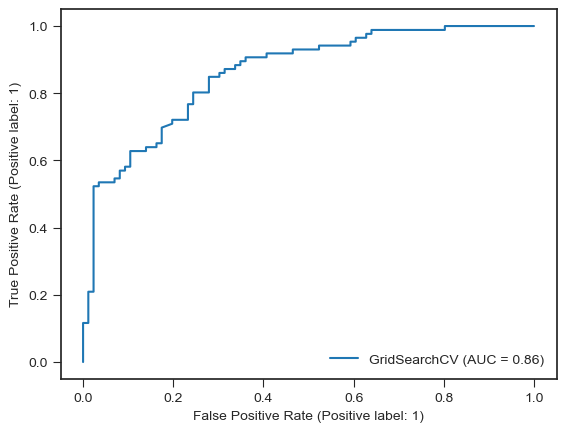

In [47]:
#metrics.plot_roc_curve(model_svm, X_test, y_test)  
RocCurveDisplay.from_estimator(model_svm, X_test, y_test)
plt.show() 

## Logistic Regression model

In [48]:
from sklearn.linear_model import LogisticRegression

In [49]:
param_grid_lr = [
  {'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100], 'classifier__solver': ['liblinear'], 'classifier__penalty': ['l1','l2']},
  {'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100], 'classifier__solver': ['lbfgs'], 'classifier__penalty': ['l2']},
 ]

In [50]:
lr = LogisticRegression(random_state=42) 
# Instantiate the grid search model

lr_flow = Pipeline([
    ('preproc', preprocessor),
    ('classifier', lr)
])

# Instantiate the grid search model with 10-fold cross-validation
model_lr = GridSearchCV(lr_flow, param_grid = param_grid_lr, cv = inner, scoring=acc_scorer)


# Fit the grid search to the data
model_lr.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=10, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preproc',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         [0, 1,
                                                                          2, 3,
                                                                          4, 5,
                                                                          6])])),
                                       ('classifier',
                                        LogisticRegression(random_state=42))]),
             param_grid=[{'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],
                          'classifier__penalty': ['l1', 'l2'],
                          'classifier__solver': ['liblinear']},
                         {'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],
                          'classifier__penalty': ['l2'],
                          'classifier__solver': ['lbfgs']}],
             scoring=make_scorer(accuracy_score))

In [51]:
model_lr.best_params_

{'classifier__C': 0.001,
 'classifier__penalty': 'l2',
 'classifier__solver': 'liblinear'}

Creating the final LR classifier with the found hyperparameters

In [52]:
y_pred_lr = model_lr.predict(X_test)

In [53]:
print(classification_report(y_test, y_pred_lr, target_names = ['non-landslide', 'landslide']))

               precision    recall  f1-score   support

non-landslide       0.73      0.71      0.72        86
    landslide       0.72      0.74      0.73        86

     accuracy                           0.73       172
    macro avg       0.73      0.73      0.73       172
 weighted avg       0.73      0.73      0.73       172



In [54]:
round(accuracy_score(y_test, y_pred_lr), 4)

0.7267

In [55]:
print(cohen_kappa_score(y_test, y_pred_lr))

0.4534883720930233


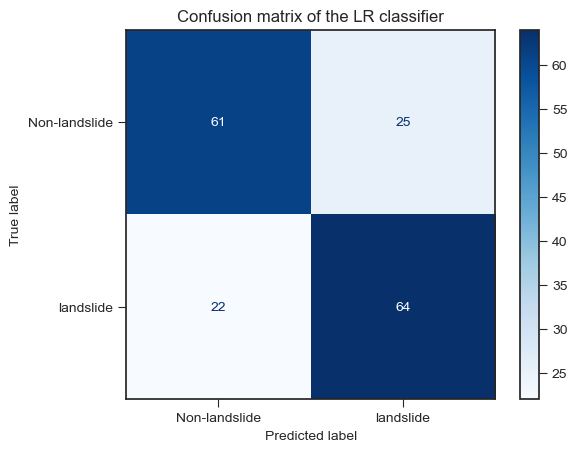

In [56]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_lr, 
                                        cmap="Blues", 
                                        display_labels=["Non-landslide", "landslide"])

plt.title('Confusion matrix of the LR classifier')
plt.show()

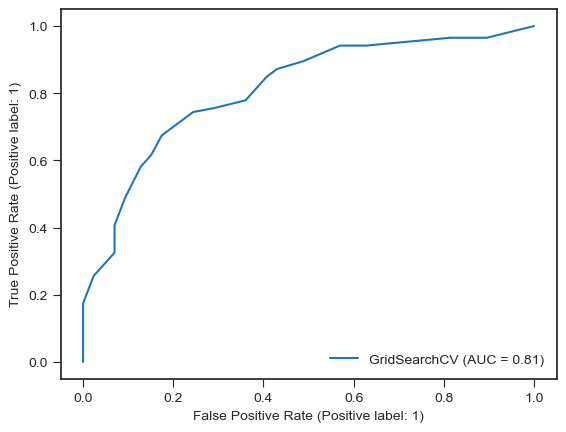

In [57]:
#metrics.plot_roc_curve(model_lr, X_test, y_test)  
RocCurveDisplay.from_estimator(model_rf, X_test, y_test)
plt.show() 

##  XGBoost

In [99]:
from xgboost import XGBClassifier

In [100]:
# Create the grid for hyperparameter tuning for XGBoost
param_grid_xgb = {
    'classifier__learning_rate': [0.01, 0.1, 0.3],
    'classifier__max_depth': [3, 4, 5, 6, 7],
    'classifier__n_estimators': [50, 100, 150],
    'classifier__gamma': [0, 0.1, 0.3, 0.5],
    'classifier__subsample': [0.6, 0.8, 1.0],
    'classifier__colsample_bytree': [0.6, 0.8, 1.0],
    'classifier__reg_alpha': [0, 0.5, 1.0],
    'classifier__reg_lambda': [0.1, 1.0, 5.0, 10.0],
    'classifier__scale_pos_weight': [1, 2, 3]
}

In [101]:
# Create a classifier
xgb = XGBClassifier(random_state=42)

In [102]:
# "Pipeline" is for making workflow with standardization and classification in a few lines of code
xgb_flow = Pipeline([
    ('preproc', preprocessor),
    ('classifier', xgb)
])

In [103]:
# Instantiate the grid search model with 10-fold cross-validation
model_xgb = GridSearchCV(xgb_flow, param_grid=param_grid_xgb, cv=kfold, scoring=acc_scorer)

In [104]:
# Fit the grid search model
model_xgb.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=10, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preproc',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         [0, 1,
                                                                          2, 3,
                                                                          4, 5,
                                                                          6])])),
                                       ('classifier',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      device=None,
                                                      early_stopping_rounds=...
             param_grid={'classifier__colsample_bytree': [0.6, 0.8, 1.0],
                         'classifier__gamma': [0, 0.1, 0.3, 0.5],
                         'classifier__learning_rate': [0.01, 0.1, 0.3],
                         'classifier__max_depth': [3, 4, 5, 6, 7],
                         'classifier__n_estimators': [50, 100, 150],
                         'classifier__reg_alpha': [0, 0.5, 1.0],
                         'classifier__reg_lambda': [0.1, 1.0, 5.0, 10.0],
                         'classifier__scale_pos_weight': [1, 2, 3],
                         'classifier__subsample': [0.6, 0.8, 1.0]},
             scoring=make_scorer(accuracy_score))

In [105]:
# Best parameters from the grid search
print("XGBoost Best Parameters:", model_xgb.best_params_)

XGBoost Best Parameters: {'classifier__colsample_bytree': 1.0, 'classifier__gamma': 0.5, 'classifier__learning_rate': 0.01, 'classifier__max_depth': 7, 'classifier__n_estimators': 100, 'classifier__reg_alpha': 0, 'classifier__reg_lambda': 5.0, 'classifier__scale_pos_weight': 1, 'classifier__subsample': 1.0}


In [106]:
# Using the test data for prediction
y_pred_xgb = model_xgb.predict(X_test)

In [107]:
# Printing classification report
print(classification_report(y_test, y_pred_xgb, target_names=['non-landslide', 'landslide']))

               precision    recall  f1-score   support

non-landslide       0.75      0.69      0.72        86
    landslide       0.71      0.77      0.74        86

     accuracy                           0.73       172
    macro avg       0.73      0.73      0.73       172
 weighted avg       0.73      0.73      0.73       172



In [108]:
# Printing confusion matrix
print(confusion_matrix(y_test, y_pred_xgb))

[[59 27]
 [20 66]]


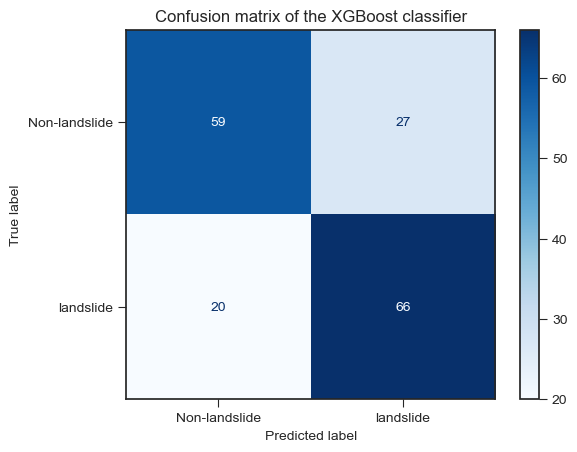

In [109]:
# Plotting confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_xgb, 
                                        cmap="Blues", 
                                        display_labels=["Non-landslide", "landslide"])
plt.title('Confusion matrix of the XGBoost classifier')
plt.show()

In [110]:
# Printing overall accuracy
print(accuracy_score(y_test, y_pred_xgb))

0.7267441860465116


In [111]:
# Checking how our model is different from a classification created by a random process
print(cohen_kappa_score(y_test, y_pred_xgb))

0.4534883720930233


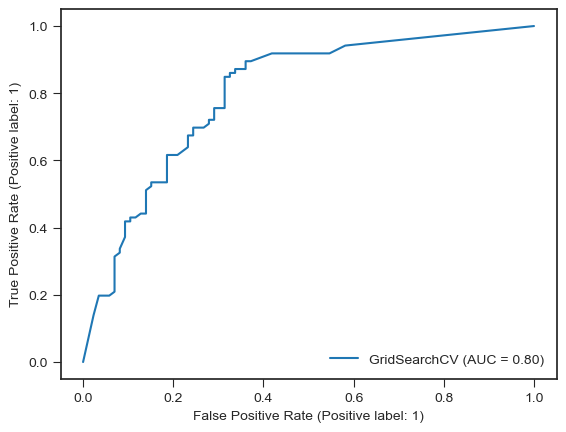

In [112]:
# Plotting ROC_AUC
RocCurveDisplay.from_estimator(model_xgb, X_test, y_test)
plt.show() 

## Plotting ROC curves for the three models

In [113]:
from sklearn.metrics import roc_auc_score, roc_curve, auc

In [114]:
pred_prob_rf=model_rf.predict_proba(X_test)[:,1]
fpr1, tpr1, threshold1 = roc_curve(y_test, pred_prob_rf, pos_label=1)
# AUC score that summarizes the ROC curve
roc_auc1 = auc(fpr1, tpr1)

In [115]:
pred_prob_svm=model_svm.predict_proba(X_test)[:,1]
fpr2, tpr2, threshold2 = roc_curve(y_test, pred_prob_svm, pos_label=1)
# AUC score that summarizes the ROC curve
roc_auc2 = auc(fpr2, tpr2)

In [75]:
pred_prob_lr=model_lr.predict_proba(X_test)[:,1]
fpr3, tpr3, threshold3 = roc_curve(y_test, pred_prob_lr, pos_label=1)
roc_auc3 = auc(fpr3, tpr3)

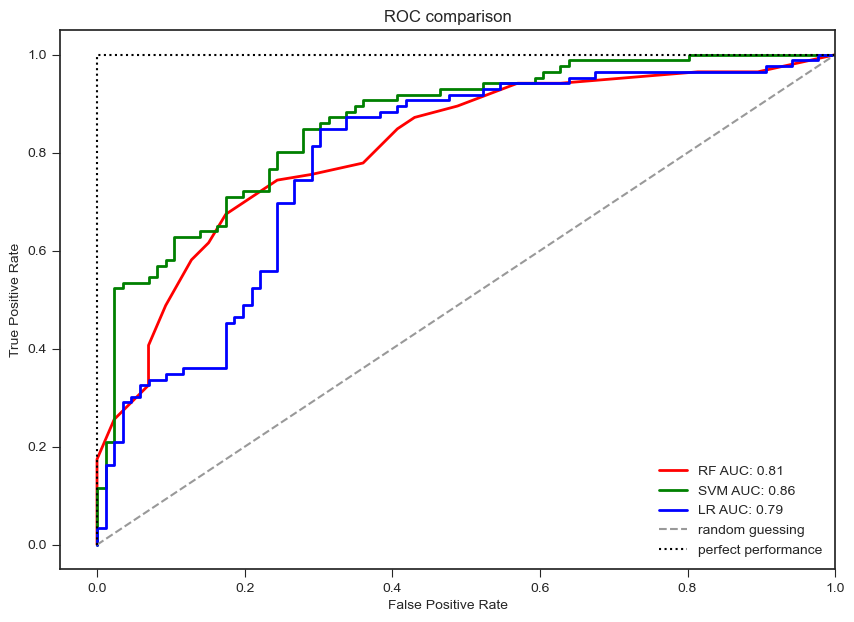

In [76]:
# AUC score that summarizes the ROC curve
f, ax = plt.subplots(figsize=(10,7))
plt.plot(fpr1,tpr1, color ='red', lw=2, label= 'RF AUC: {:.2f}'.format(roc_auc1))
plt.plot(fpr2,tpr2, color ='green', lw=2, label='SVM AUC: {:.2f}'.format(roc_auc2))
plt.plot(fpr3,tpr3, color ='blue', lw=2, label='LR AUC: {:.2f}'.format(roc_auc3))
plt.plot([0, 1], [0, 1],
         linestyle = '--',
         color = (0.6, 0.6, 0.6),
         label = 'random guessing')
plt.plot([0, 0, 1], [0, 1, 1],
         linestyle = ':',
         color = 'black', 
         label = 'perfect performance')
plt.xlim([-.05, 1.0])
plt.ylim([-.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC comparison')
plt.legend(loc="lower right")

plt.savefig(r'D:\\Yenbai_PCA\fig/AUC.png', bbox_inches='tight', dpi=600)
plt.show()




## External Validation on the dataset outside of our AOI

Reading the data (landslide absence and presence points). The data is unseen by the models, as it comes outside of the AOI, and it has not earlier been used for training or testing

In [70]:
external_val_data=pd.read_csv(r"D:\\Yenbai_PCA\external_validation\sample_points_external_validation(remove_collerated_data).csv")

dropping the columns with climate variables

In [71]:
#external_val_data= external_val_data.drop(columns=['average_temp_ref', 'cloudburst_ref', 'groundwater_ref', 'rain_average_ref', 'rain_max_day_ref'])
#external_val_data= external_val_data.drop(columns=['profile_curvature', 'slope', 'roughness', 'planform_curvature'])

In [72]:
external_val_data.head()

,dem_elevation,lulc,ndvi,ndwi,rivers,roads,lithology,faults,twi,spi,tri,slope,aspect,profile,plan,Landslide
0,32,5,6,-0.732988,6,50,22,501,7.632720,294.007172,11.269427,20.674463,147.994614,0.003828,0.004573,1
1,43,2,6,-0.342311,1,50,16,501,8.648936,73.012177,4.582576,6.454830,315.000000,-0.004709,-0.070711,1
2,98,3,6,-0.652853,4,500,22,501,8.193690,376.277313,10.000000,17.874008,262.874970,-0.011289,-0.018930,1
3,34,7,1,-0.207725,5,50,22,501,8.187958,333.835663,10.000000,16.942358,156.801407,-0.007631,-0.013402,1
4,35,3,1,-0.706716,1,50,37,501,7.534921,389.437714,12.649111,24.516314,52.125015,-0.000148,-0.027634,1


In [73]:
external_val_data.describe()

,dem_elevation,lulc,ndvi,ndwi,rivers,roads,lithology,faults,twi,spi,tri,slope,aspect,profile,plan,Landslide
count,616.000000,616.000000,616.000000,616.000000,616.000000,616.000000,616.000000,616.000000,616.000000,616.000000,616.000000,616.000000,616.000000,616.000000,616.000000,616.000000
mean,267.189935,5.129870,2.948052,-0.654817,2.943182,302.331169,21.930195,437.074675,8.147763,792.504706,9.296764,15.970813,174.687431,0.000114,0.001852,0.500000
std,285.249572,1.408228,2.282609,0.134702,1.507171,197.355436,10.370847,141.068954,1.339906,2821.928193,4.541808,7.835646,102.644106,0.006491,0.041697,0.500406
min,5.000000,1.000000,0.000000,-0.844942,1.000000,50.000000,2.000000,50.000000,5.703938,0.000000,1.000000,0.000000,0.000000,-0.025356,-0.320000,0.000000
25%,52.500000,5.000000,1.000000,-0.746380,2.000000,100.000000,15.000000,500.000000,7.212619,80.833504,5.722636,10.142106,90.000000,-0.004676,-0.016323,0.000000
50%,149.500000,5.000000,1.000000,-0.692668,3.000000,200.000000,23.000000,501.000000,7.828366,216.614761,9.460407,16.235792,165.963760,0.000000,0.000000,0.500000
75%,407.750000,6.000000,6.000000,-0.608891,4.000000,501.000000,29.000000,501.000000,8.675798,497.385857,11.884850,20.780418,270.000000,0.004868,0.018991,1.000000
max,1680.000000,7.000000,6.000000,0.183173,6.000000,501.000000,38.000000,501.000000,14.146332,37606.957030,26.019224,40.157703,360.000000,0.025371,0.320000,1.000000


In [74]:
external_val_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 616 entries, 0 to 615
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   dem_elevation  616 non-null    int64  
 1   lulc           616 non-null    int64  
 2   ndvi           616 non-null    int64  
 3   ndwi           616 non-null    float64
 4   rivers         616 non-null    int64  
 5   roads          616 non-null    int64  
 6   lithology      616 non-null    int64  
 7   faults         616 non-null    int64  
 8   twi            616 non-null    float64
 9   spi            616 non-null    float64
 10  tri            616 non-null    float64
 11  slope          616 non-null    float64
 12  aspect         616 non-null    float64
 13  profile        616 non-null    float64
 14  plan           616 non-null    float64
 15  Landslide      616 non-null    int64  
dtypes: float64(8), int64(8)
memory usage: 77.1 KB


dropping null values

In [75]:
external_val_data=external_val_data.dropna()

In [76]:
external_val_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 616 entries, 0 to 615
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   dem_elevation  616 non-null    int64  
 1   lulc           616 non-null    int64  
 2   ndvi           616 non-null    int64  
 3   ndwi           616 non-null    float64
 4   rivers         616 non-null    int64  
 5   roads          616 non-null    int64  
 6   lithology      616 non-null    int64  
 7   faults         616 non-null    int64  
 8   twi            616 non-null    float64
 9   spi            616 non-null    float64
 10  tri            616 non-null    float64
 11  slope          616 non-null    float64
 12  aspect         616 non-null    float64
 13  profile        616 non-null    float64
 14  plan           616 non-null    float64
 15  Landslide      616 non-null    int64  
dtypes: float64(8), int64(8)
memory usage: 77.1 KB


In [77]:
external_val_data['Landslide'].value_counts()

Landslide
1    308
0    308
Name: count, dtype: int64

Dividing the data into variables and the labels

In [78]:
X_val = external_val_data.iloc[:, 0:-1]

In [79]:
X_val.head()

,dem_elevation,lulc,ndvi,ndwi,rivers,roads,lithology,faults,twi,spi,tri,slope,aspect,profile,plan
0,32,5,6,-0.732988,6,50,22,501,7.632720,294.007172,11.269427,20.674463,147.994614,0.003828,0.004573
1,43,2,6,-0.342311,1,50,16,501,8.648936,73.012177,4.582576,6.454830,315.000000,-0.004709,-0.070711
2,98,3,6,-0.652853,4,500,22,501,8.193690,376.277313,10.000000,17.874008,262.874970,-0.011289,-0.018930
3,34,7,1,-0.207725,5,50,22,501,8.187958,333.835663,10.000000,16.942358,156.801407,-0.007631,-0.013402
4,35,3,1,-0.706716,1,50,37,501,7.534921,389.437714,12.649111,24.516314,52.125015,-0.000148,-0.027634


In [80]:
y_val = external_val_data["Landslide"]

## SVM

Predicting the classes of the external validation data with our trained SVM classifier

In [81]:
y_pred_svm_val = model_svm.predict(X_val)

Printing overall accuracy

In [82]:
from sklearn.metrics import accuracy_score
round(accuracy_score(y_val, y_pred_svm_val),4)

0.539

In [83]:
# Checking how our model is different from a classification created by a random process
print(cohen_kappa_score(y_val, y_pred_svm_val))

0.07792207792207795


In [84]:
print(classification_report(y_val, y_pred_svm_val, target_names = ['non-landslide', 'landslide']))

               precision    recall  f1-score   support

non-landslide       0.63      0.19      0.29       308
    landslide       0.52      0.89      0.66       308

     accuracy                           0.54       616
    macro avg       0.58      0.54      0.48       616
 weighted avg       0.58      0.54      0.48       616



Plotting confusion matrix

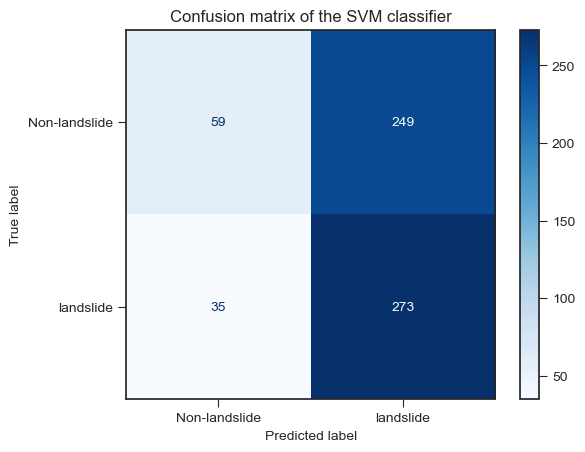

In [85]:
ConfusionMatrixDisplay.from_predictions(y_val, y_pred_svm_val, 
                                        cmap="Blues", 
                                        display_labels=["Non-landslide", "landslide"])

plt.title('Confusion matrix of the SVM classifier')
plt.show()

Repeating the process with RF and LR

## Random Forest

In [87]:
y_pred_rf_val = model_rf.predict(X_val)

In [88]:
from sklearn.metrics import accuracy_score
round(accuracy_score(y_val, y_pred_rf_val), 4)

0.8084

In [89]:
print(cohen_kappa_score(y_val, y_pred_rf_val))

0.6168831168831168


In [90]:
print(classification_report(y_val, y_pred_rf_val, target_names = ['non-landslide', 'landslide']))

               precision    recall  f1-score   support

non-landslide       0.83      0.77      0.80       308
    landslide       0.79      0.84      0.82       308

     accuracy                           0.81       616
    macro avg       0.81      0.81      0.81       616
 weighted avg       0.81      0.81      0.81       616



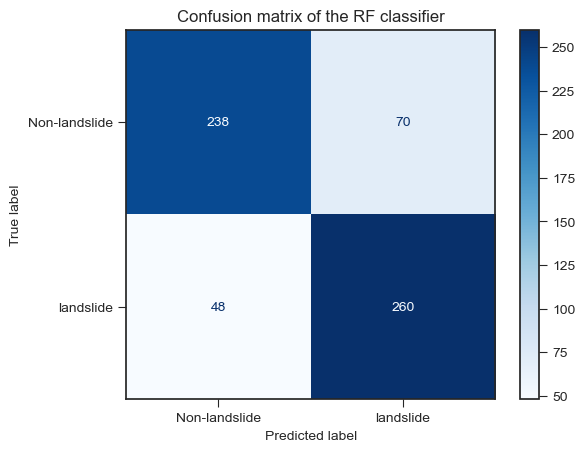

In [91]:
ConfusionMatrixDisplay.from_predictions(y_val, y_pred_rf_val, 
                                        cmap="Blues", 
                                        display_labels=["Non-landslide", "landslide"])

plt.title('Confusion matrix of the RF classifier')
plt.show()

## Logistic Regression

In [93]:
y_pred_lr_val = model_lr.predict(X_val)

In [94]:
from sklearn.metrics import accuracy_score
round(accuracy_score(y_val, y_pred_lr_val), 4)

0.5633

In [95]:
print(cohen_kappa_score(y_val, y_pred_lr_val))

0.12662337662337664


In [96]:
print(classification_report(y_val, y_pred_svm_val, target_names = ['non-landslide', 'landslide']))

               precision    recall  f1-score   support

non-landslide       0.63      0.19      0.29       308
    landslide       0.52      0.89      0.66       308

     accuracy                           0.54       616
    macro avg       0.58      0.54      0.48       616
 weighted avg       0.58      0.54      0.48       616



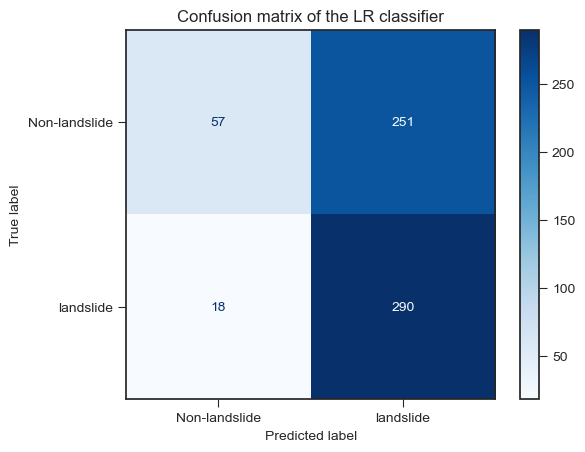

In [97]:
ConfusionMatrixDisplay.from_predictions(y_val, y_pred_lr_val, 
                                        cmap="Blues", 
                                        display_labels=["Non-landslide", "landslide"])

plt.title('Confusion matrix of the LR classifier')
plt.show()

## XG Boost

In [116]:
# Predicting with the trained XGBoost model
y_pred_xgb_val = model_xgb.predict(X_val)

In [117]:
# Printing overall accuracy
from sklearn.metrics import accuracy_score
print("XGBoost Validation Accuracy:", round(accuracy_score(y_val, y_pred_xgb_val), 4))

XGBoost Validation Accuracy: 0.8263


In [118]:
print(cohen_kappa_score(y_val, y_pred_xgb_val))

0.6525974025974026


In [119]:
print(classification_report(y_val, y_pred_xgb_val, target_names = ['non-landslide', 'landslide']))

               precision    recall  f1-score   support

non-landslide       0.84      0.81      0.82       308
    landslide       0.82      0.84      0.83       308

     accuracy                           0.83       616
    macro avg       0.83      0.83      0.83       616
 weighted avg       0.83      0.83      0.83       616



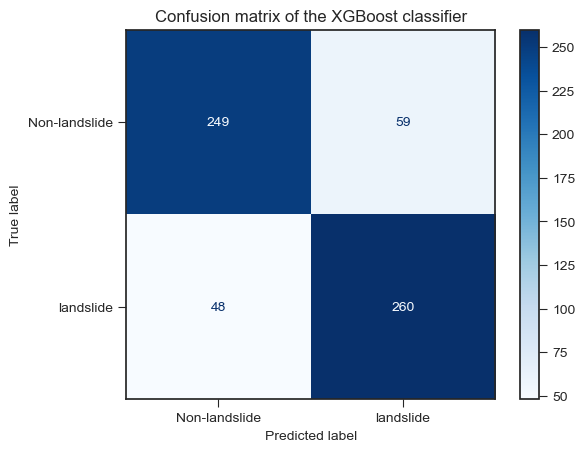

In [120]:
# Plotting confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(y_val, y_pred_xgb_val, 
                                        cmap="Blues", 
                                        display_labels=["Non-landslide", "landslide"])
plt.title('Confusion matrix of the XGBoost classifier')
plt.show()

## Making susceptibility maps with our trained classifiers

Predicting probability with trained RF classifier

In [85]:
result_rf = stack.predict_proba(model_rf)

Plotting probabilities

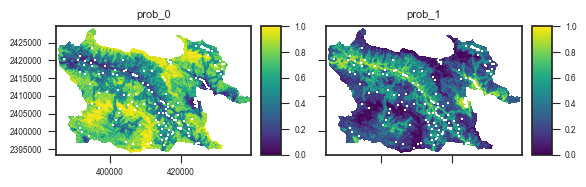

In [86]:
result_rf.plot()
plt.show()

Saving the result as a .tif file

In [87]:
result_rf.write(r"probability_rf_without_climate_variables.tif")

Raster Object Containing 2 Layers
    attribute                                             values
0       names                                   [prob_0, prob_1]
1       files  [probability_rf_without_climate_variables.tif,...
2        rows                                               2896
3        cols                                               4413
4         res                                       (12.5, 12.5)
5  nodatavals  [-3.4028234663852886e+38, -3.4028234663852886e...


Repeating it with LR

In [88]:
result_lr = stack.predict_proba(estimator=model_lr)

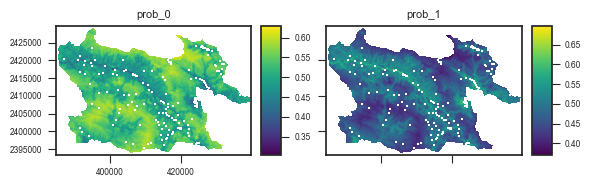

In [89]:
result_lr.plot()
plt.show()

In [90]:
result_lr.write(r"probability_lr_without_climate_variables.tif")

Raster Object Containing 2 Layers
    attribute                                             values
0       names                                   [prob_0, prob_1]
1       files  [probability_lr_without_climate_variables.tif,...
2        rows                                               2896
3        cols                                               4413
4         res                                       (12.5, 12.5)
5  nodatavals  [-3.4028234663852886e+38, -3.4028234663852886e...


and SVM

In [91]:
result_svm = stack.predict_proba(estimator=model_svm)

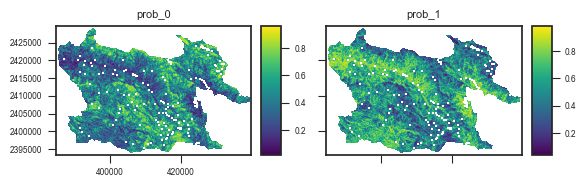

In [92]:
result_svm.plot()
plt.show()

In [93]:
result_svm.write(r"probability_svm_without_climate_variables.tif")

Raster Object Containing 2 Layers
    attribute                                             values
0       names                                   [prob_0, prob_1]
1       files  [probability_svm_without_climate_variables.tif...
2        rows                                               2896
3        cols                                               4413
4         res                                       (12.5, 12.5)
5  nodatavals  [-3.4028234663852886e+38, -3.4028234663852886e...


In [97]:
# Predicting probability with trained XGBoost classifier
result_xgb = stack.predict_proba(estimator=model_xgb)

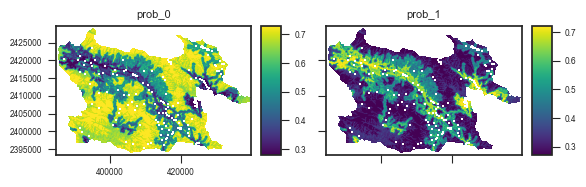

In [98]:
# Plotting probabilities
result_xgb.plot()
plt.show()

In [100]:
#Saving the result as a .tif file
result_xgb.write(r"probability_xgb_without_climate_variables.tif")

Raster Object Containing 2 Layers
    attribute                                             values
0       names                                   [prob_0, prob_1]
1       files  [probability_xgb_without_climate_variables.tif...
2        rows                                               2896
3        cols                                               4413
4         res                                       (12.5, 12.5)
5  nodatavals  [-3.4028234663852886e+38, -3.4028234663852886e...


The end